In [1]:
# this notebook should stay in root
import json
import pickle

# Load the JSON data
with open('filtered_data_PF00959.p', 'rb') as file:
    data = pickle.load(file)

with open('random_selection_2000_PF00959.p', 'rb') as file:
    data_ood = pickle.load(file)

In [2]:
data[0]

{'metadata': {'accession': 'A0A009F987',
  'name': 'Lysozyme',
  'source_database': 'unreviewed',
  'length': 164,
  'source_organism': {'taxId': '1310618',
   'scientificName': 'Acinetobacter baumannii 118362',
   'fullName': 'Acinetobacter baumannii 118362'}},
 'entries': [{'accession': 'PF00959',
   'entry_protein_locations': [{'fragments': [{'start': 65,
       'end': 163,
       'dc-status': 'CONTINUOUS'}],
     'model': 'PF00959',
     'score': 5e-21}],
   'protein_length': 164,
   'source_database': 'pfam',
   'entry_type': 'domain',
   'entry_integrated': 'ipr002196'}],
 'sequence': {'metadata': {'accession': 'A0A009F987',
   'id': 'A0A009F987_ACIBA',
   'source_organism': {'taxId': '1310618',
    'scientificName': 'Acinetobacter baumannii 118362',
    'fullName': 'Acinetobacter baumannii 118362'},
   'name': 'Lysozyme',
   'description': None,
   'length': 164,
   'sequence': 'MTTKPFFDAARVIAGGKLTQAQVDELNKVVNKLAPGGKTTSDFGVNLITGFEGTRFTAYDDGVGVWTIGTGTTVYPNGVKVKKGDTCTAEQAKTYFKHDLA

In [3]:
# Extract accessions from random_selection_data
ood_accessions = {entry['metadata']['accession'] for entry in data_ood}

# Filter out entries in filtered_data that are in random_selection_data
filtered_data = [entry for entry in data if entry['metadata']['accession'] not in ood_accessions]

In [4]:
len(filtered_data)

17473

In [9]:
def lysozyme_to_fasta(sequences, file_name="output.fasta"):
    with open(file_name, 'w') as file:
        for seq in sequences:
            # Extracting accession identifier and sequence
            accession = seq['sequence']['metadata']['accession']
            sequence = seq['sequence']['metadata']['sequence']
            # Writing the header with accession identifier
            file.write(f">{accession}\n")
            # Writing the amino acid sequence
            file.write(f"{sequence}\n")

lysozyme_to_fasta(filtered_data, file_name="lysozymes_trainingdb.fasta")

In [5]:
# for DRY RUN 
#filtered_data = filtered_data[:100]
#len(filtered_data)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def compute_len(data):
    len_all = []
    oo = 0
    for entry in data:
        try:
            tmp_len = entry['sequence']['metadata']['length']
        except KeyError: 
            tmp_len = entry['sequence']['length']
        if tmp_len <= 1300:
            len_all.append(tmp_len)
        else:
            oo+=1
    print('00: ', oo)
    return len_all

def plot_histogram(data, bin_step, name):
    # Create the histogram
    max_val = max(data)
    bin_edges = list(range(0, max_val + bin_step, bin_step))
    #print(bin_edges)
    plt.figure(figsize=(11, 6))
    n, bins, _ = plt.hist(data, bins=bin_edges, color=(180/255, 211/255, 178/255), edgecolor='black', alpha=0.99, rwidth=0.87)    
    print(n)
    print(bins)
    # Title, labels, and legend
    plt.title('Histogram of Sequence Length Ranges')
    plt.xlabel('Sequence Length')
    plt.ylabel('Number of Instances')
    plt.legend()
    plt.savefig(name + '_Histogram.svg')
    # Display the plot
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


00:  2
[1.574e+03 3.020e+02 9.700e+01 1.200e+01 1.200e+01 1.000e+00]
[   0.  200.  400.  600.  800. 1000. 1200.]


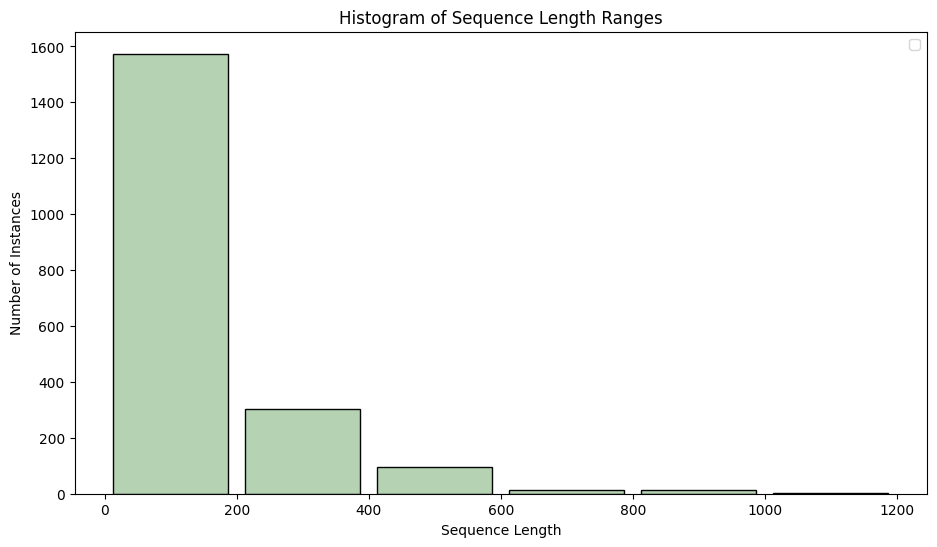

In [8]:
#with open('data/sampled_data_validation_2000_PF00959.p', 'rb') as file:
#    data_val = pickle.load(file)
#with open('data_random_selection_uniParc/random_selection_2000.p', 'rb') as file:
#    data_val = pickle.load(file)
#print(data_val[0])
with open('sampled_data_validation_2000_PF00959.p', 'rb') as file:
    data_val = pickle.load(file)

len_data = compute_len(data_val) #data_ood
plot_histogram(len_data, 200, 'PF_validation_2000')

In [170]:
import random
# Ensure the filtered_data has at least 2000 entries
sampled_data = None
if len(filtered_data) < 2000:
    print("There are less than 2000 entries in the filtered_data!")
else:
    sampled_data = random.sample(filtered_data, 2000)


In [23]:
# Extract accessions from filtered_data
accessions = [entry['metadata']['accession'] for entry in filtered_data]

# Check for duplicates
unique_accessions = set(accessions)
if len(unique_accessions) != len(accessions):
    print(f"There are {len(accessions) - len(unique_accessions)} duplicates in the filtered_data.")
else:
    print("There are no duplicates in the filtered_data.")


There are no duplicates in the filtered_data.


In [24]:
# Save the sampled_data to a pickle file
with open('data/sampled_data_validation_2000_PF00959.p', 'wb') as file:
    pickle.dump(sampled_data, file)

print("Sampled data saved successfully!")

Sampled data saved successfully!


In [25]:
# Save the filtered_data to a pickle file
with open('data/filtered_data_training_PF00959.p', 'wb') as file:
    pickle.dump(filtered_data, file)

print("Filtered data saved successfully!")

Filtered data saved successfully!


<h3>Saving training data in the correct format</h3>

In [35]:
# we assign the ctrl keywrd 0 to the lisozyme family for fine-tuning
def convert_to_desired_format(data):
    uid = data['metadata']['accession']
    sequence = data['sequence']['metadata']['sequence']
    # predefined keyword
    keyword = 0
    return {
        uid: {
            'seq': sequence,
            'kw': [keyword]
        }
    }

def convert_all_data(all_data):
    converted_dataset = {}
    for data_instance in all_data:
        converted_dataset.update(convert_to_desired_format(data_instance))
    return converted_dataset

In [36]:
data_formatted = convert_all_data(filtered_data)

In [37]:
len(data_formatted)

100

In [38]:
data_formatted['A0A009F987']

{'seq': 'MTTKPFFDAARVIAGGKLTQAQVDELNKVVNKLAPGGKTTSDFGVNLITGFEGTRFTAYDDGVGVWTIGTGTTVYPNGVKVKKGDTCTAEQAKTYFKHDLAKFEKTVNESVTVPINQNQFDALVSLTYNIGSGAFKGSTLLKLLNKGDYQGAADQFLVWNKAGG',
 'kw': [0]}

In [39]:
import os
def convert_and_save_in_chunks(data_formatted, base_path, num_chunks=10):
    # Calculate the size of each chunk
    chunk_size = len(data_formatted) // num_chunks
    items = list(data_formatted.items())
    
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size if i != num_chunks - 1 else None  # To handle the last chunk which might be larger
        chunk = dict(items[start_idx:end_idx])

        # Save the chunk to a pickle file
        with open(base_path + 'train' + str(i) + '.p', 'wb') as f:
            pickle.dump(chunk, f)
            

In [40]:
# Assuming your data is loaded in a variable named 'dataset'
convert_and_save_in_chunks(data_formatted, 'data/train_test_pkl_dry_run/')

In [32]:
# Save as a pickle file
with open('data/training_data_PF00959_formatted.p', 'wb') as file:
    pickle.dump(data_formatted, file)